In [1]:
import re
import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import tqdm.notebook
import gensim

In [2]:
df = pd.read_pickle('final_short_stopwords_extended.pkl')
df.head()

,name,region,text,likes,reposts,date,lines_processed,lines_lemmatized
0,Подслушано Охтинский Колледж,г.Санкт-Петебург,НУ И ДА \nПРО ДИПЛОМЫ/КУРСОВЫЕ \nХУЙНЮ ПРО ВОЙ...,66,11,2022-10-09 18:44:59,дипломыкурсовые хуйню войну выкладываем хватит...,"[дипломыкурсовой, хуйня, война, выкладывать, х..."
4,Подслушано Охтинский Колледж,г.Санкт-Петебург,"+1/2 в кс на турик, если был фейсит у вас то ж...",3,0,2024-02-23 09:45:54,кс турик фейсит желательно лвл выше рейтинг кс...,"[кс, турик, фейсить, желательно, лвл, выше, ре..."
5,Подслушано Охтинский Колледж,г.Санкт-Петебург,"вот такой шикарный вид открывается на респе, м...",33,1,2024-02-22 14:17:07,шикарный вид открывается респе мужик решил пос...,"[шикарный, вид, открываться, респ, мужик, реша..."
6,Подслушано Охтинский Колледж,г.Санкт-Петебург,Ребят нужен челик на 2 поз для турика от шараг...,6,9,2024-02-21 11:51:13,ребят нужен челик поз турика шараги доте желат...,"[нужный, челик, поза, турик, шарага, дот, жела..."
8,Подслушано Охтинский Колледж,г.Санкт-Петебург,"анонимно/ тяночки из бухарестской, отзовитесь,...",9,1,2024-02-16 05:28:44,тяночки бухарестской отзовитесь дайте контакты...,"[тяночка, бухарестский, отзываться, контакт, к..."


In [3]:
df['post_date'] = pd.to_datetime(df['date'])
df['year'] = df['post_date'].dt.year

<Axes: xlabel='year'>

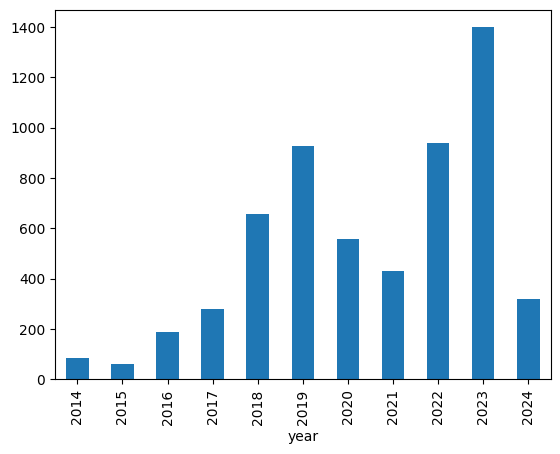

In [4]:
discussions_per_year = df.groupby(['year'])['post_date'].count()
discussions_per_year.plot.bar()

<Axes: xlabel='region'>

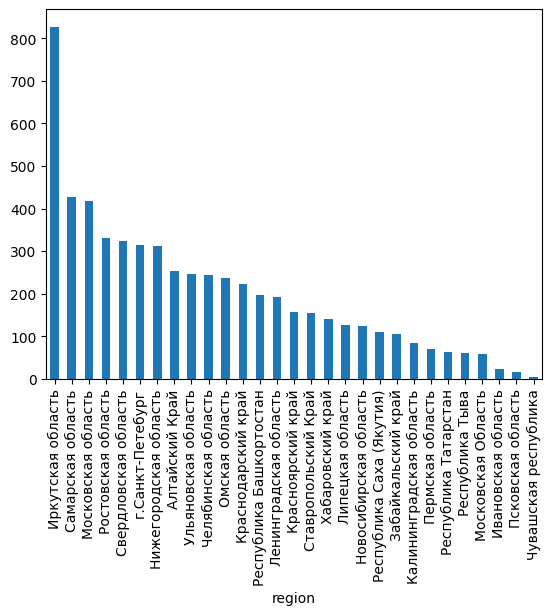

In [8]:
df['region'].value_counts().plot(kind='bar')

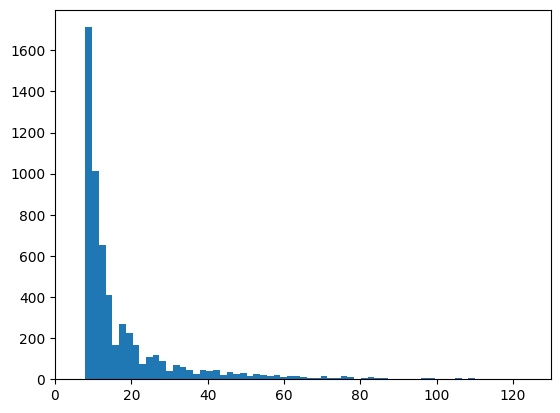

In [14]:
df['length'] = df['lines_lemmatized'].apply(len)
plt.hist(df['length'], bins=500)

# Set x-axis limit to 600
plt.xlim(0, 130)

# Show plot
plt.show()

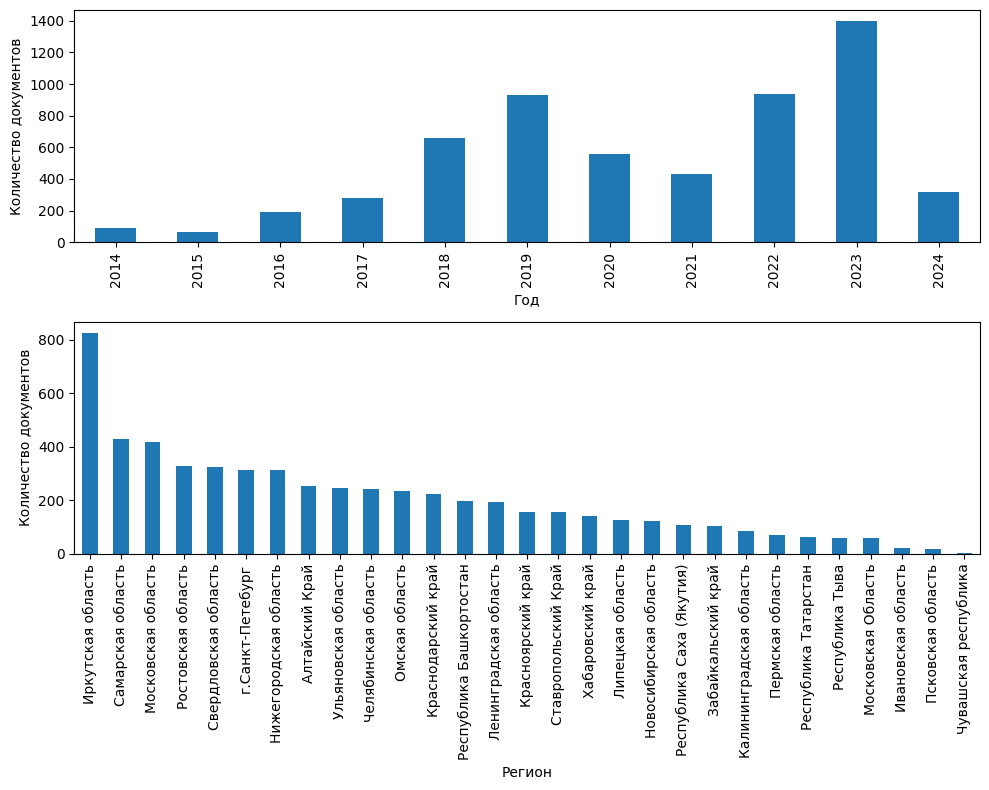

In [88]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

discussions_per_year = df.groupby(['year'])['post_date'].count()
discussions_per_year.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Год')
ax1.set_ylabel('Количество документов')

region_counts = df['region'].value_counts()
region_counts.plot(kind='bar', ax=ax2)
ax2.set_xlabel('Регион')
ax2.set_ylabel('Количество документов')

plt.tight_layout()

plt.show()


In [4]:
data_words = df['lines_lemmatized'].to_numpy()

In [5]:
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [6]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in tqdm.notebook.tqdm(texts, leave=False)]

In [7]:
data_words_bigrams = make_bigrams(data_words)

  0%|          | 0/5845 [00:00<?, ?it/s]

## Создание словаря

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

In [28]:
print(f'Размер словаря до фильтрации: {len(id2word)}')

Размер словаря до фильтрации: 23163


In [29]:
id2word.filter_extremes(no_below=3, no_above=0.3)
print(f'Размер словаря после фильтрации: {len(id2word)}')

Размер словаря после фильтрации: 6607


In [30]:
# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in tqdm.notebook.tqdm(texts, leave=False)]

  0%|          | 0/5845 [00:00<?, ?it/s]

## Поиск количества тем

In [32]:
from tqdm import tqdm_notebook
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, limit, step)):

        model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=42,
            alpha=0.1,
            eta=0.1,
            chunksize=100,
            passes=10,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
from tqdm import tqdm_notebook
def compute_coherence_values1(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Credits: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm_notebook(range(start, limit, step)):

        model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=42,
            alpha= 0.3,
            eta = 0.3,
            chunksize=100,
            passes=10,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=texts,
    start=5, limit=35, step=5
)

C:\Users\user\AppData\Local\Temp\ipykernel_4188\785029751.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_topics in tqdm_notebook(range(start, limit, step)):


  0%|          | 0/6 [00:00<?, ?it/s]

In [37]:
model_list1, coherence_values1 = compute_coherence_values1(
    dictionary=id2word,
    corpus=corpus,
    texts=texts,
    start=5, limit=35, step=5
)

C:\Users\user\AppData\Local\Temp\ipykernel_4188\1366945526.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num_topics in tqdm_notebook(range(start, limit, step)):


  0%|          | 0/6 [00:00<?, ?it/s]

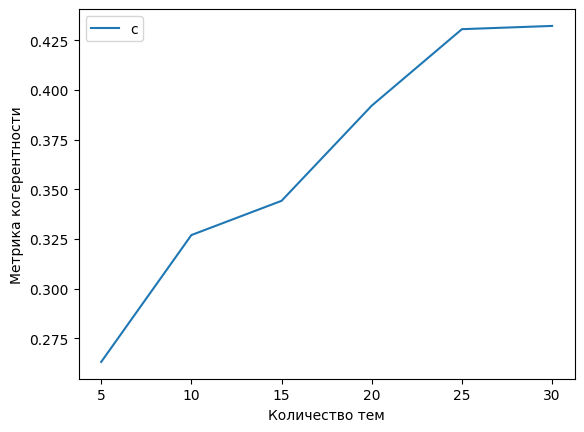

In [34]:
import matplotlib.pyplot as plt
x = range(5, 35, 5)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Метрика когерентности")
plt.legend(("coherence_values"), loc='best')
plt.show()

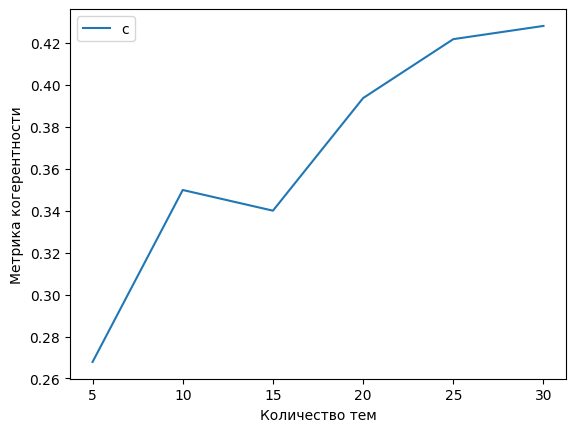

In [38]:
import matplotlib.pyplot as plt
x = range(5, 35, 5)
plt.plot(x, coherence_values1)
plt.xlabel("Количество тем")
plt.ylabel("Метрика когерентности")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Обучение модели с оптимальным числом топиков

In [39]:
%%time
final_model = gensim.models.ldamulticore.LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=30,
            random_state=42,
            chunksize=2000,
            passes=20,
            alpha = 0.05,
            eta = 0.3
        )

CPU times: total: 24.7 s
Wall time: 34.6 s


In [40]:
coherencemodel = CoherenceModel(model=final_model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()


0.3442436274301241

In [41]:
topics = final_model.show_topics(num_topics=30, num_words=10, formatted=True)

In [42]:
for topic in topics:
  print("Topic {}: ".format(topic[0]+1)+"\n\t"+('\n\t'.join([x.strip() for x in topic[1].replace('*',':\t\t').split('+')]))+"\n")

Topic 1: 
	0.005:		"ребенок"
	0.003:		"работа"
	0.003:		"й"
	0.003:		"любой"
	0.003:		"окно"
	0.003:		"место"
	0.003:		"получать"
	0.003:		"колледж"
	0.003:		"также"
	0.003:		"июнь"

Topic 2: 
	0.003:		"предлагать"
	0.002:		"работа"
	0.002:		"рядом"
	0.002:		"сука"
	0.002:		"песня"
	0.002:		"конкурс"
	0.002:		"закрывать"
	0.002:		"запрещать"
	0.002:		"друг"
	0.002:		"дискотека"

Topic 3: 
	0.020:		"ребенок"
	0.008:		"родитель"
	0.006:		"праздник"
	0.005:		"проект"
	0.004:		"работа"
	0.004:		"жизнь"
	0.003:		"ученик"
	0.003:		"заниматься"
	0.003:		"трезвость"
	0.003:		"работать"

Topic 4: 
	0.011:		"команда"
	0.006:		"турнир"
	0.006:		"поздравлять"
	0.005:		"д"
	0.005:		"пж"
	0.004:		"игра"
	0.004:		"проходить"
	0.004:		"жизнь"
	0.003:		"место"
	0.003:		"любимый"

Topic 5: 
	0.004:		"фотография"
	0.003:		"лс"
	0.003:		"деньги"
	0.003:		"фото"
	0.003:		"комент"
	0.003:		"просить"
	0.003:		"мероприятие"
	0.003:		"ученик"
	0.003:		"дискотека"
	0.003:		"декабрь"

Topic 6: 
	0.005:		"нахуй"


## Другой метод - GSMDD

In [43]:
from gsdmm import MovieGroupProcess
from tqdm import tqdm

vocab_length = len(id2word)

gsdmm = MovieGroupProcess(K=20, alpha=0.1, beta=0.1, n_iters=30)

y = tqdm(gsdmm.fit(df['lines_lemmatized'].to_numpy(), vocab_length))

In stage 0: transferred 5003 clusters with 20 clusters populated
In stage 1: transferred 2864 clusters with 20 clusters populated
In stage 2: transferred 1796 clusters with 20 clusters populated
In stage 3: transferred 1274 clusters with 20 clusters populated
In stage 4: transferred 1081 clusters with 20 clusters populated
In stage 5: transferred 955 clusters with 20 clusters populated
In stage 6: transferred 899 clusters with 20 clusters populated
In stage 7: transferred 828 clusters with 20 clusters populated
In stage 8: transferred 832 clusters with 20 clusters populated
In stage 9: transferred 786 clusters with 20 clusters populated
In stage 10: transferred 790 clusters with 20 clusters populated
In stage 11: transferred 760 clusters with 20 clusters populated
In stage 12: transferred 756 clusters with 20 clusters populated
In stage 13: transferred 747 clusters with 20 clusters populated
In stage 14: transferred 721 clusters with 20 clusters populated
In stage 15: transferred 715 c

  0%|          | 0/5845 [00:00<?, ?it/s]

In [44]:
import os
import pickle
file = 'gsdmm_v2.model'
with open(os.path.join('C:/Users/user/Desktop/NLP_project/', file), 'wb') as f:
 pickle.dump(gsdmm, f)
 f.close()

## Оценивание GSDMM

In [45]:
file = 'gsdmm_v2.model'
gsdmm = pickle.load(open(os.path.join('C:/Users/user/Desktop/NLP_project/', file), 'rb'))
gsdmm.cluster_doc_count

[241,
 261,
 288,
 179,
 314,
 482,
 275,
 195,
 223,
 174,
 650,
 418,
 177,
 266,
 182,
 218,
 259,
 284,
 510,
 249]

In [46]:
doc_count = np.array(gsdmm.cluster_doc_count)
print('Количество документов, отведённых в топик:', doc_count)

top_index = doc_count.argsort()[-20:][::-1]
print('Наиболее важные кластеры (по количеству документов внутри):', top_index)

def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

top_words(gsdmm.cluster_word_distribution, top_index, 20)

Количество документов, отведённых в топик: [241 261 288 179 314 482 275 195 223 174 650 418 177 266 182 218 259 284
 510 249]
Наиболее важные кластеры (по количеству документов внутри): [10 18  5 11  4  2 17  6 13  1 16 19  0  8 15  7 14  3 12  9]

Cluster 10 : [('потерять', 223), ('вернуть', 151), ('черный', 126), ('телефон', 111), ('лс', 107), ('просьба', 96), ('кабинет', 92), ('ктото', 91), ('вахта', 72), ('этаж', 70), ('никто', 69), ('белый', 68), ('карта', 68), ('отдавать', 67), ('наушники', 65), ('раздевалка', 63), ('просить', 62), ('чехол', 59), ('забирать', 57), ('потеряться', 53)]

Cluster 18 : [('выкладывать', 61), ('друг', 57), ('запись', 51), ('предлагать', 50), ('предложка', 49), ('сообщество', 45), ('никто', 40), ('кидать', 39), ('паблик', 37), ('удалять', 37), ('слово', 35), ('родитель', 35), ('создавать', 34), ('просить', 33), ('комментарий', 33), ('мнение', 32), ('ребенок', 32), ('подслушок', 32), ('подслушивать', 30), ('хватить', 30)]

Cluster 5 : [('туалет', 100), ('

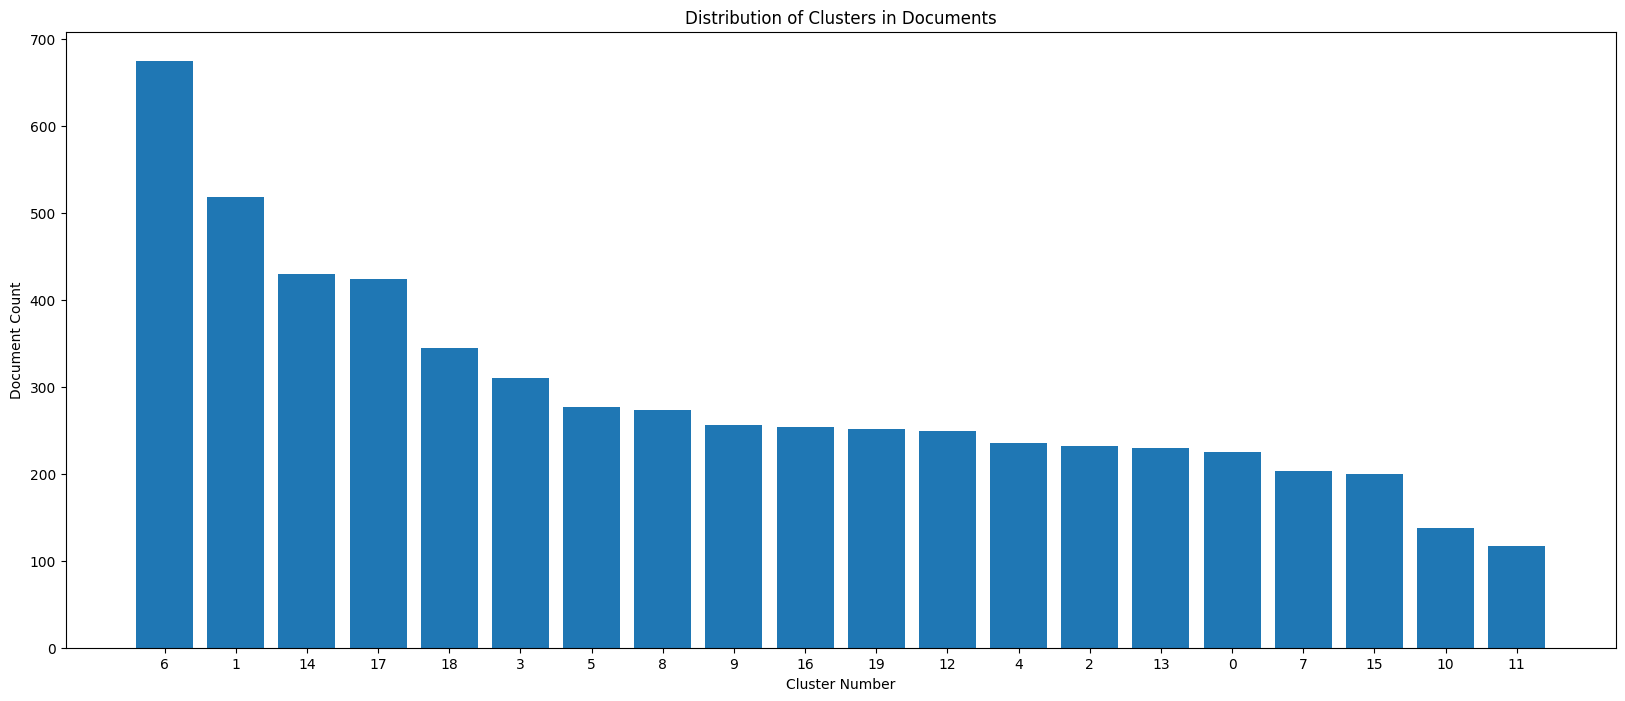

In [46]:
dict_doc_count = dict(zip(range(len(doc_count)), doc_count))
dict_doc_count= (sorted(dict_doc_count.items(), key=lambda x: x[1], reverse=True))
x_val = [str(x[0]) for x in dict_doc_count]
y_val = [x[1] for x in dict_doc_count]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(x_val, y_val)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Document Count')
ax.set_title('Distribution of Clusters in Documents');

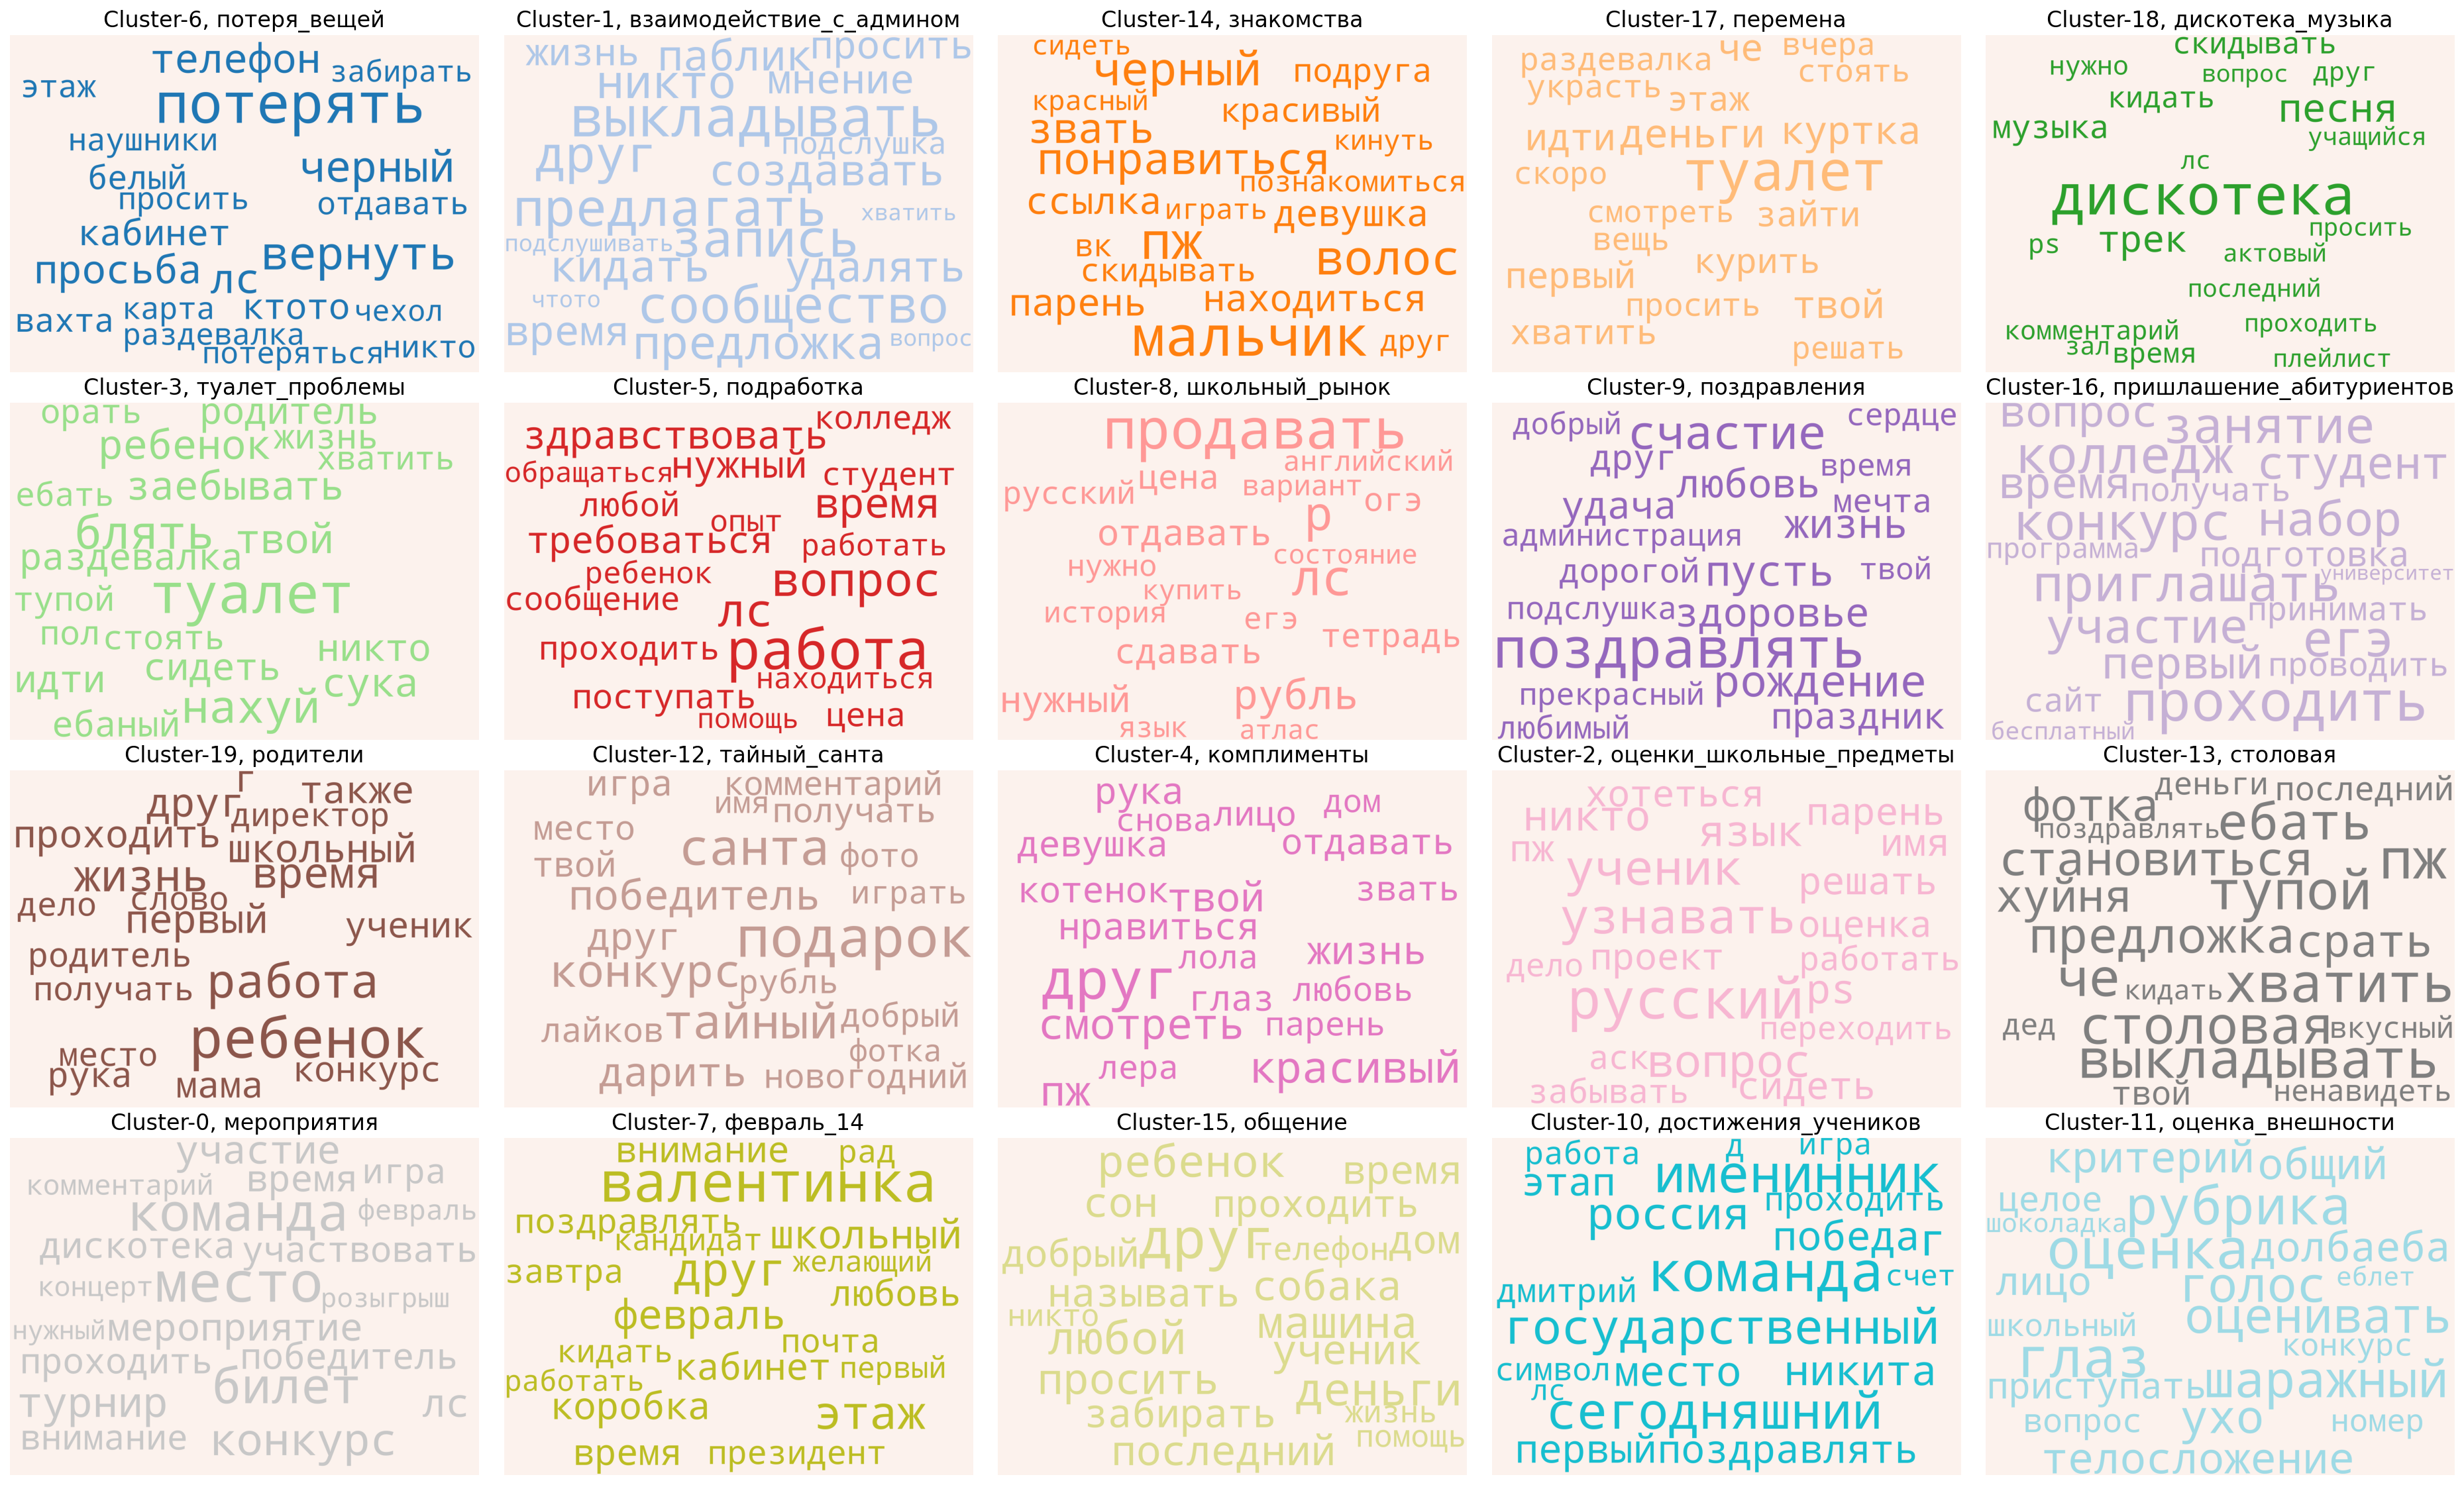

In [86]:
from wordcloud import WordCloud
cluster_word_distribution = gsdmm.cluster_word_distribution

fig, axes = plt.subplots(4,5,figsize=(25,15), sharex=True, sharey=True, dpi=150)

values = 20 # top 25 words
cloud = WordCloud(background_color='#fcf2ed',
                  width=2500,
                  height=1800,
                  max_words=values,
                  prefer_horizontal=1.0)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  topic_dict = sorted(cluster_word_distribution[top_index[i]].items(), key=lambda k: k[1], reverse=True)[:values] 
  cloud.generate_from_frequencies(dict(topic_dict), max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title(f'Cluster-{top_index[i]}, {themes_20[i]}', fontdict=dict(size=16))
  plt.gca().axis('off')

# Print to screen
# plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


In [78]:
# манипуляции с результатами модели GSDMM для использования в CoherenceModel
def get_topics_lists(model, top_clusters, n_words):

    # лист для сбора топиков
    topics = []
    
    # итерирование через топ кластеры
    for cluster in top_clusters:
        # словарь распределения слов
        sorted_dict = sorted(model.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:n_words]
         
        topic = []
        
        for k,v in sorted_dict:
            topic.append(k)
             
        topics.append(topic)
    
    return topics

topics = get_topics_lists(gsdmm, top_index, 20) 

cm_gsdmm = CoherenceModel(topics=topics, 
                          dictionary=id2word, 
                          corpus=corpus, 
                          texts=texts, 
                          coherence='c_v')

coherence_gsdmm = cm_gsdmm.get_coherence()  

print(coherence_gsdmm)

0.3103385288652278


In [81]:
themes_20 = {
    0: 'потеря_вещей',
    1: 'взаимодействие_с_админом',
    2: 'знакомства',
    3: 'перемена',
    4: 'дискотека_музыка',
    5: 'туалет_проблемы',
    6: 'подработка',
    7: 'школьный_рынок',
    8: 'поздравления',
    9: 'пришлашение_абитуриентов',
    10: 'родители',
    11: 'тайный_санта',
    12: 'комплименты',
    13: 'оценки_школьные_предметы',
    14: 'столовая',
    15: 'мероприятия',
    16: 'февраль_14',
    17: 'общение',
    18: 'достижения_учеников',
    19: 'оценка_внешности'
}

## Вторая попытка

In [66]:
vocab_length1 = len(id2word)

gsdmm1 = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=50)

y1 = tqdm(gsdmm1.fit(df['lines_lemmatized'].to_numpy(), vocab_length1))

In stage 0: transferred 4721 clusters with 10 clusters populated
In stage 1: transferred 2663 clusters with 10 clusters populated
In stage 2: transferred 1470 clusters with 10 clusters populated
In stage 3: transferred 1128 clusters with 10 clusters populated
In stage 4: transferred 919 clusters with 10 clusters populated
In stage 5: transferred 815 clusters with 10 clusters populated
In stage 6: transferred 745 clusters with 10 clusters populated
In stage 7: transferred 737 clusters with 10 clusters populated
In stage 8: transferred 670 clusters with 10 clusters populated
In stage 9: transferred 666 clusters with 10 clusters populated
In stage 10: transferred 679 clusters with 10 clusters populated
In stage 11: transferred 669 clusters with 10 clusters populated
In stage 12: transferred 645 clusters with 10 clusters populated
In stage 13: transferred 651 clusters with 10 clusters populated
In stage 14: transferred 640 clusters with 10 clusters populated
In stage 15: transferred 630 cl


  0%|          | 0/5845 [08:32<?, ?it/s]


In [67]:
file1 = 'gsdmm_v2.model1'
with open(os.path.join('C:/Users/user/Desktop/NLP_project/', file1), 'wb') as f:
 pickle.dump(gsdmm1, f)
 f.close()

In [68]:
file1 = 'gsdmm_v2.model1'
gsdmm1 = pickle.load(open(os.path.join('C:/Users/user/Desktop/NLP_project/', file1), 'rb'))
gsdmm1.cluster_doc_count

[1061, 640, 395, 500, 831, 365, 807, 485, 408, 353]

In [69]:
doc_count1 = np.array(gsdmm1.cluster_doc_count)
print('Количество документов, отведённых в топик:', doc_count1)

top_index1 = doc_count1.argsort()[-20:][::-1]
print('Наиболее важные кластеры (по количеству документов внутри):', top_index1)

top_words(gsdmm1.cluster_word_distribution, top_index1, 10)

Количество документов, отведённых в топик: [1061  640  395  500  831  365  807  485  408  353]
Наиболее важные кластеры (по количеству документов внутри): [0 4 6 1 3 7 8 2 5 9]

Cluster 0 : [('потерять', 233), ('черный', 198), ('вернуть', 155), ('лс', 136), ('телефон', 123), ('просьба', 107), ('ктото', 105), ('мальчик', 101), ('кабинет', 98), ('белый', 96)]

Cluster 4 : [('друг', 86), ('выкладывать', 66), ('че', 52), ('пж', 50), ('парень', 48), ('фотка', 47), ('оценка', 44), ('хватить', 43), ('твой', 42), ('становиться', 39)]

Cluster 6 : [('дискотека', 146), ('комментарий', 85), ('друг', 83), ('время', 77), ('сообщество', 77), ('запись', 75), ('просить', 66), ('предлагать', 65), ('кидать', 65), ('конкурс', 65)]

Cluster 1 : [('туалет', 127), ('этаж', 47), ('деньги', 39), ('хватить', 39), ('раздевалка', 39), ('дверь', 34), ('столовая', 32), ('никто', 31), ('блять', 30), ('сидеть', 30)]

Cluster 3 : [('работа', 93), ('команда', 82), ('проходить', 73), ('вопрос', 72), ('время', 63), ('лс

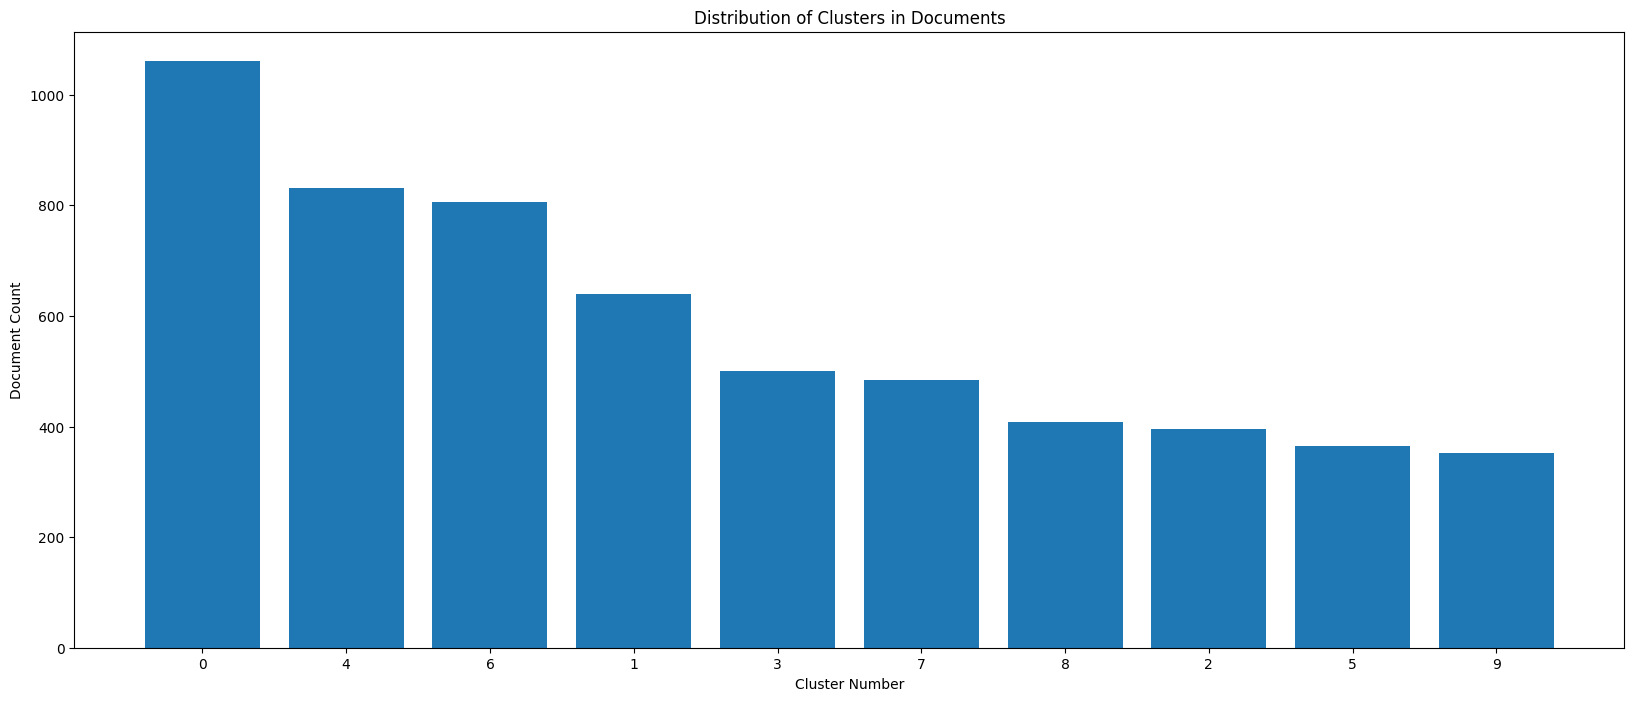

In [70]:
dict_doc_count1 = dict(zip(range(len(doc_count1)), doc_count1))
dict_doc_count1= (sorted(dict_doc_count1.items(), key=lambda x: x[1], reverse=True))
x_val1 = [str(x[0]) for x in dict_doc_count1]
y_val1 = [x[1] for x in dict_doc_count1]

fig, ax = plt.subplots(figsize=(20,8))
ax.bar(x_val1, y_val1)
ax.set_xlabel('Cluster Number')
ax.set_ylabel('Document Count')
ax.set_title('Distribution of Clusters in Documents');